## Weather Data : Visualization After Smoothing

### For New York State

In [1]:
%run '../spark_variables.ipynb'

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [4]:
!rm -r ../Data/Weather/NY.*
!ls ../Data/Weather

STAT_NY.pickle            WA.tgz                    recon_NY_SNWD.parquet
STAT_WA.pickle            Weather_Stations.tgz      stations.parquet
US_stations.tsv           decon_NY_PRCP_s20.parquet
WA.parquet                decon_NY_SNWD.parquet


In [5]:
state='WA'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/WA.tgz > ../Data/Weather/WA.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.4M  100 61.4M    0     0  4524k      0  0:00:13  0:00:13 --:--:-- 10.4M0:00:50  0:00:04  0:00:46 1242k 2284k      0  0:00:27  0:00:11  0:00:16 3233k  0  3846k      0  0:00:16  0:00:13  0:00:03 7712k
-rw-r--r--  1 brianroepke  staff    61M Sep 28 08:05 ../Data/Weather/WA.tgz


In [6]:
!ls -l $data_dir

total 329896
-rw-r--r--   1 brianroepke  staff  51365103 Sep 22 12:44 STAT_NY.pickle
-rw-r--r--   1 brianroepke  staff  51366605 Sep 28 07:54 STAT_WA.pickle
-rw-r--r--   1 brianroepke  staff    731305 Sep 22 12:44 US_stations.tsv
drwxr-xr-x  31 brianroepke  staff       992 Sep 28 07:54 WA.parquet
-rw-r--r--   1 brianroepke  staff  64485728 Sep 28 08:05 WA.tgz
-rw-r--r--   1 brianroepke  staff    353056 Sep 28 07:55 Weather_Stations.tgz
drwxr-xr-x   8 brianroepke  staff       256 Sep 22 12:35 decon_NY_PRCP_s20.parquet
drwxr-xr-x  10 brianroepke  staff       320 Sep 22 12:30 decon_NY_SNWD.parquet
drwxr-xr-x  10 brianroepke  staff       320 Sep 22 12:31 recon_NY_SNWD.parquet
drwxr-xr-x   9 brianroepke  staff       288 Sep 28 07:55 stations.parquet


In [7]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather
 74M	./WA.parquet
/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Section2-Weather-PCA_PART1


In [8]:
!du -h $data_dir/$parquet

 74M	../Data/Weather/WA.parquet


In [9]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

WA.parquet
number of rows= 177336


In [10]:
weather_df.show(1)

+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|          longitude|        elevation|state|      name|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
|USC00459342|       PRCP|1901|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|WIND RIVER|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
only showing top 1 row



### read statistics information for state.

In [11]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_WA.pickle.gz > ../Data/Weather/STAT_WA.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.0M  100 32.0M    0     0  23.6M      0  0:00:01  0:00:01 --:--:-- 23.6M


In [12]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

../Data/Weather/STAT_WA.pickle.gz
-rw-r--r--  1 brianroepke  staff  33572191 Sep 28 08:06 ../Data/Weather/STAT_WA.pickle.gz


In [13]:
print(gzpath)
!gunzip -f $gzpath
!ls -l $data_dir

../Data/Weather/STAT_WA.pickle.gz
total 329896
-rw-r--r--   1 brianroepke  staff  51365103 Sep 22 12:44 STAT_NY.pickle
-rw-r--r--   1 brianroepke  staff  51366605 Sep 28 08:06 STAT_WA.pickle
-rw-r--r--   1 brianroepke  staff    731305 Sep 22 12:44 US_stations.tsv
drwxr-xr-x  31 brianroepke  staff       992 Sep 28 08:05 WA.parquet
-rw-r--r--   1 brianroepke  staff  64485728 Sep 28 08:05 WA.tgz
-rw-r--r--   1 brianroepke  staff    353056 Sep 28 07:55 Weather_Stations.tgz
drwxr-xr-x   8 brianroepke  staff       256 Sep 22 12:35 decon_NY_PRCP_s20.parquet
drwxr-xr-x  10 brianroepke  staff       320 Sep 22 12:30 decon_NY_SNWD.parquet
drwxr-xr-x  10 brianroepke  staff       320 Sep 22 12:31 recon_NY_SNWD.parquet
drwxr-xr-x   9 brianroepke  staff       288 Sep 28 07:55 stations.parquet


In [14]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'),allow_pickle=True)


In [15]:
Measurements = STAT.keys()
Measurements

dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])

In [16]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [17]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   353k      0 --:--:-- --:--:-- --:--:--  353k


In [18]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather
152224	WA.parquet
26200	decon_NY_PRCP_s20.parquet
3840	decon_NY_SNWD.parquet
3840	recon_NY_SNWD.parquet
832	stations.parquet
/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Section2-Weather-PCA_PART1


In [19]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [20]:
weather_df.join?

Signature: weather_df.join(other, on=None, how=None)
Docstring:
Joins with another :class:`DataFrame`, using the given join expression.

:param other: Right side of the join
:param on: a string for the join column name, a list of column names,
    a join expression (Column), or a list of Columns.
    If `on` is a string or a list of strings indicating the name of the join column(s),
    the column(s) must exist on both sides, and this performs an equi-join.
:param how: str, default ``inner``. Must be one of: ``inner``, ``cross``, ``outer``,
    ``full``, ``full_outer``, ``left``, ``left_outer``, ``right``, ``right_outer``,
    ``left_semi``, and ``left_anti``.

The following performs a full outer join between ``df1`` and ``df2``.

>>> df.join(df2, df.name == df2.name, 'outer').select(df.name, df2.height).collect()
[Row(name=None, height=80), Row(name='Bob', height=85), Row(name='Alice', height=None)]

>>> df.join(df2, 'name', 'outer').select('name', 'height').collect()
[Row(name='Tom',

In [21]:
jdf=weather_df.drop('name').join(stations_df,on='Station',how='left')
jdf.show(3)

+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|          longitude|        elevation|state|Dist_coast|Latitude|Longitude|Elevation|State|      Name|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|USC00459342|       PRCP|1901|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1906|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1907|[00 7E 00 7E 00 7...|126.

In [22]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+------------+-----+
|        Name|count|
+------------+-----+
|     PROSSER| 1612|
|     ROSALIA| 1428|
|   OLGA 2 SE| 1424|
|   SUNNYSIDE| 1422|
|DAYTON 1 WSW| 1410|
+------------+-----+
only showing top 5 rows



In [23]:
#find how many measurements of each type for a particlar station
stat='PROSSER'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  140|
|       TMIN|  140|
|   SNOW_s20|  134|
|       TOBS|  126|
|   SNWD_s20|  128|
|   PRCP_s20|  138|
|   TOBS_s20|  126|
|       TMAX|  140|
|       SNOW|  134|
|   TMAX_s20|  140|
|       SNWD|  128|
|       PRCP|  138|
+-----------+-----+



In [50]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(50)

+----+-----+
|Year|count|
+----+-----+
|1938|   24|
|1949|   24|
|1959|   24|
|1954|   24|
|1933|   24|
|1962|   24|
|1946|   24|
|1939|   24|
|1942|   24|
|1945|   24|
|1935|   24|
|1951|   24|
|1960|   24|
|1950|   24|
|1955|   24|
|1931|   24|
|1948|   24|
|1937|   24|
|1957|   24|
|1953|   24|
|1956|   24|
|1936|   24|
|1932|   24|
|1941|   24|
|1944|   24|
|1947|   24|
|1961|   24|
|1940|   24|
|1943|   24|
|1958|   24|
|1934|   22|
|1926|   22|
|1952|   22|
|1925|   20|
|1927|   20|
|1929|   20|
|1928|   20|
|1930|   20|
|1963|   18|
|1972|   12|
|1984|   12|
|2003|   12|
|2006|   12|
|1986|   12|
|1915|   12|
|1918|   12|
|1983|   12|
|1920|   12|
|1975|   12|
|1998|   12|
+----+-----+
only showing top 50 rows



In [25]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,state,Dist_coast,Latitude,Longitude,Elevation,State,Name
Measurement,,,,,,,,,,,,,,
TMAX_s20,USC00456768,2007,"[203, 79, 200, 79, 197, 79, 193, 79, 194, 79, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
PRCP_s20,USC00456768,2007,"[87, 73, 60, 73, 27, 73, 255, 72, 226, 72, 203...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
TMIN_s20,USC00456768,2007,"[226, 208, 235, 208, 245, 208, 252, 208, 1, 20...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
TOBS_s20,USC00456768,2007,"[145, 204, 167, 204, 186, 204, 201, 204, 215, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
SNWD_s20,USC00456768,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
SNOW_s20,USC00456768,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
PRCP,USC00456768,2007,"[0, 0, 0, 0, 96, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
SNOW,USC00456768,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER
SNWD,USC00456768,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.934006,46.201401,-119.758102,253.0,WA,233.934006,46.201401,-119.758102,253.0,WA,PROSSER


## Plots

In [46]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

['TOBS', 'PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']

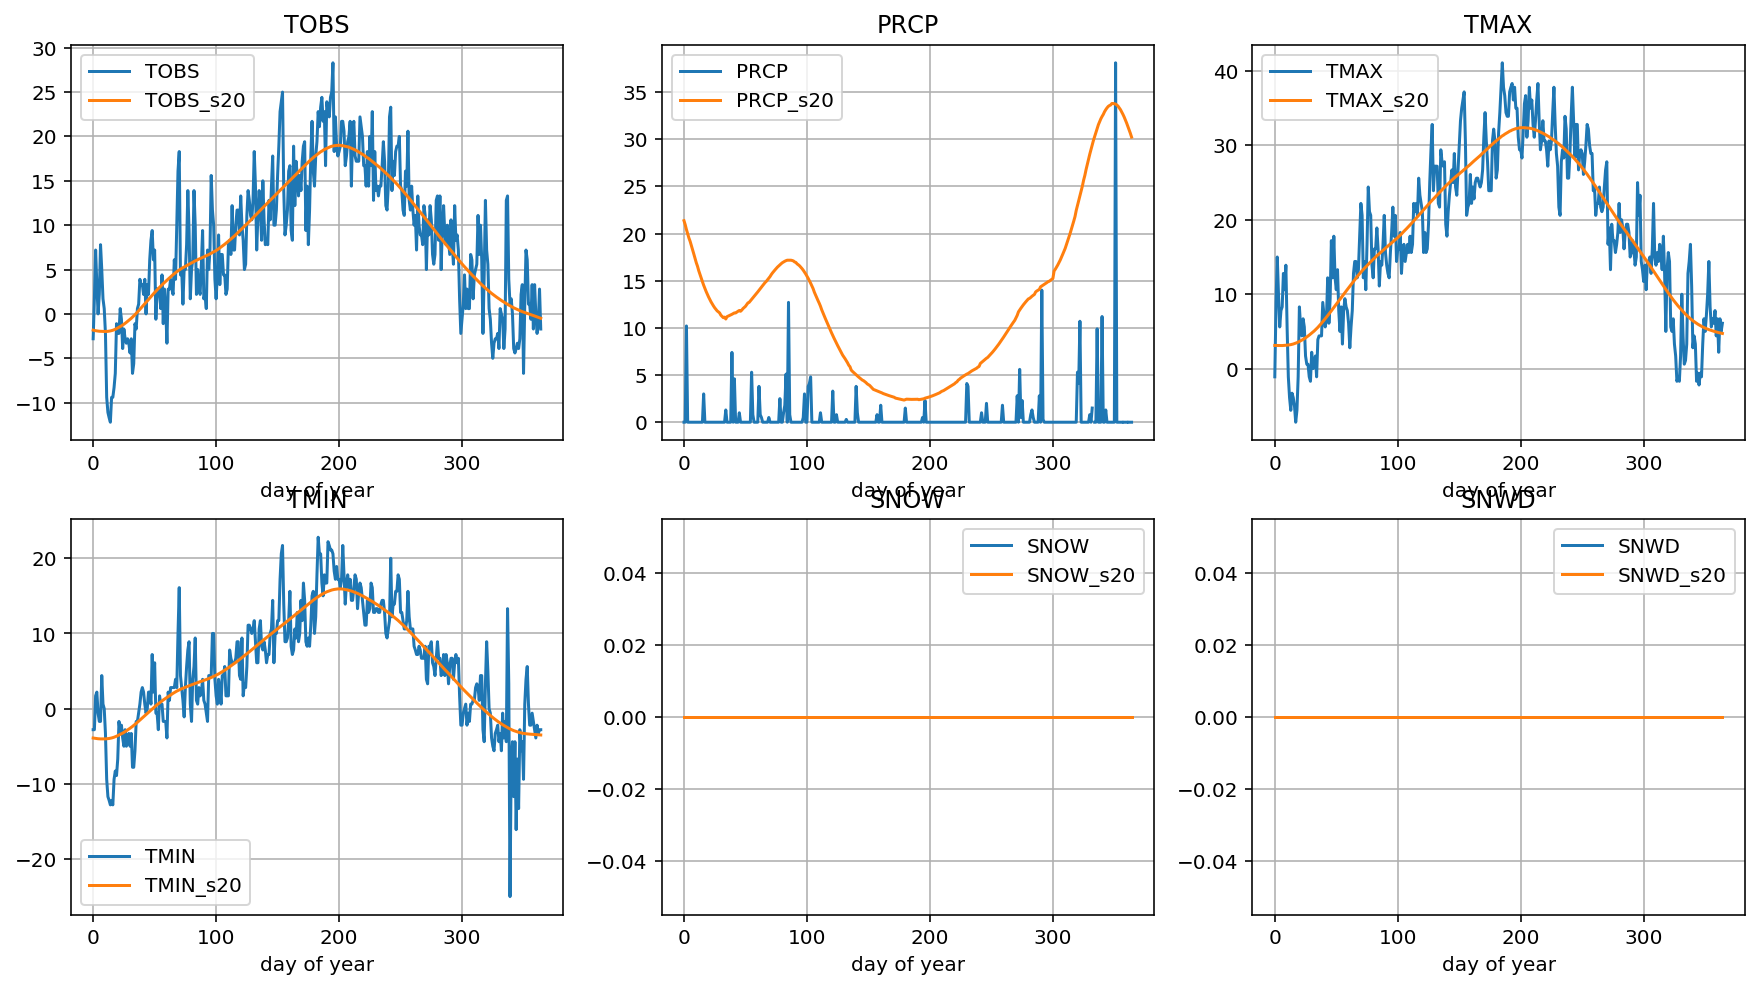

In [47]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [28]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

### Plots of mean and std of observations

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [30]:
from lib.MultiPlot import *

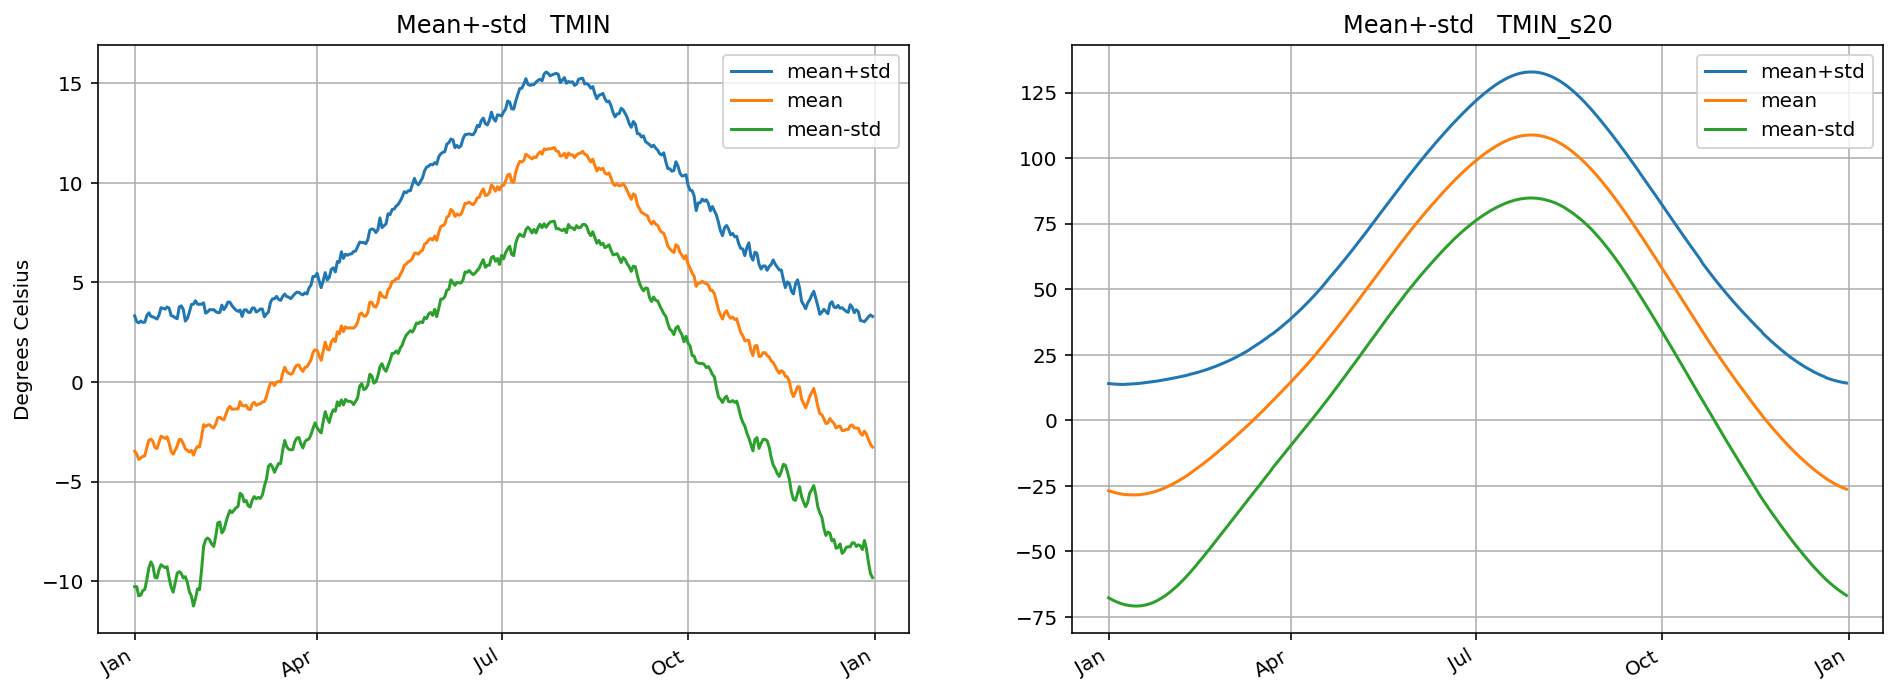

In [31]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

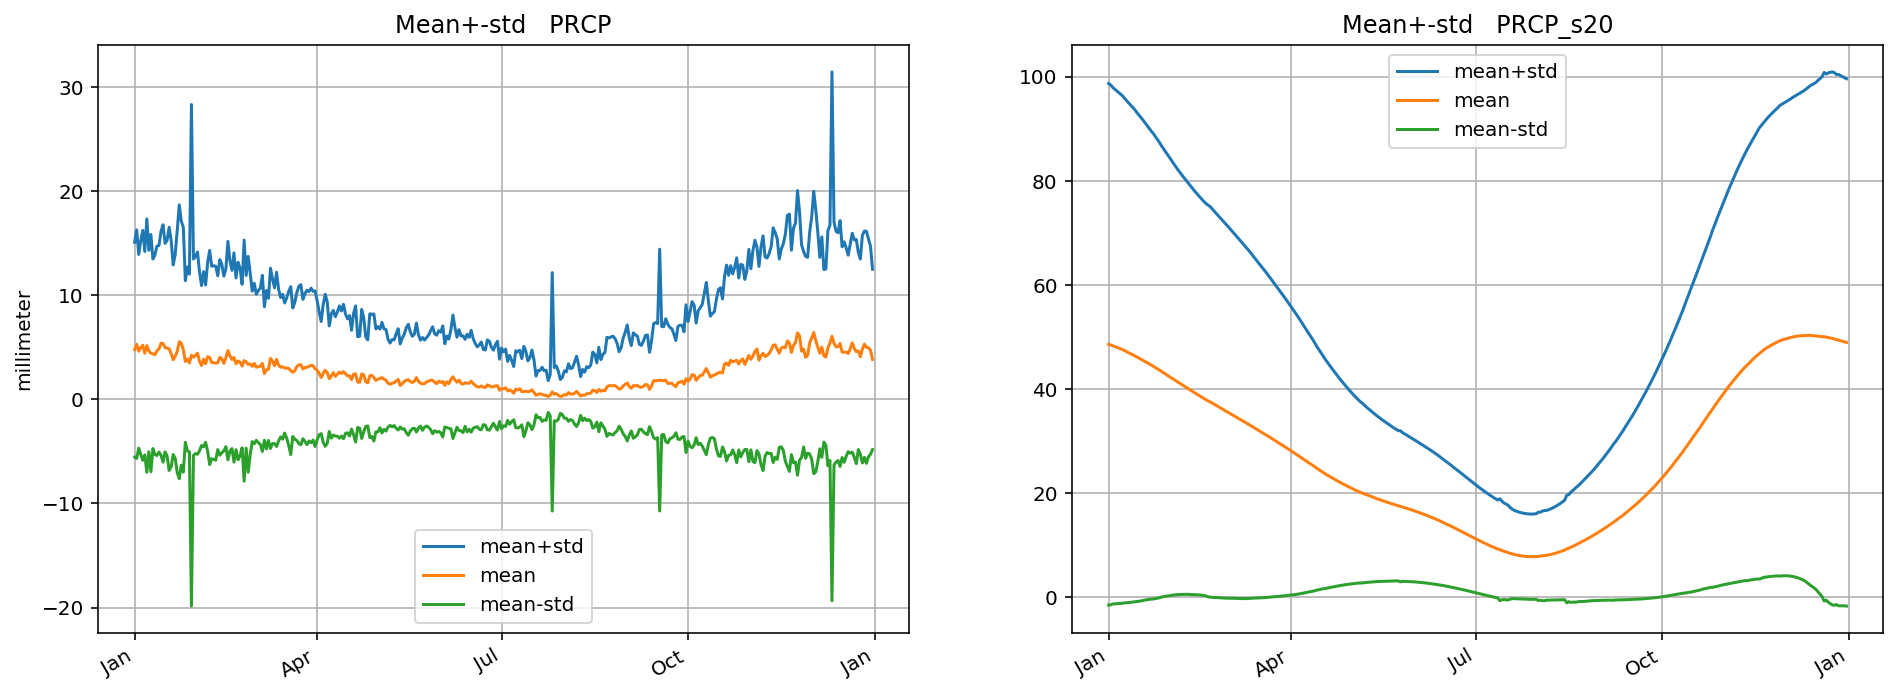

In [32]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

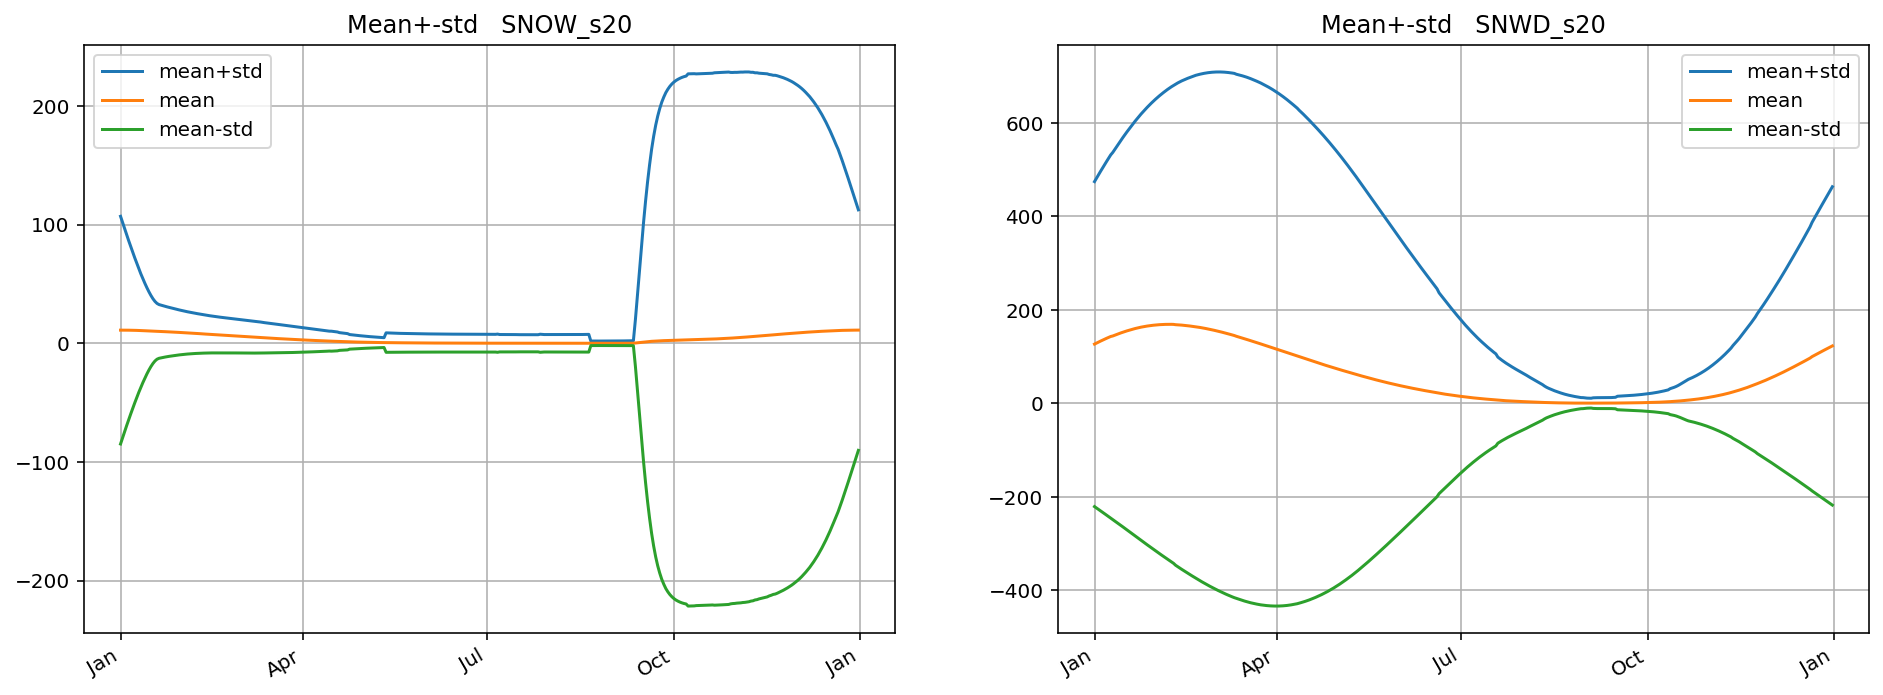

In [33]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [34]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [35]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: r_figures: File exists


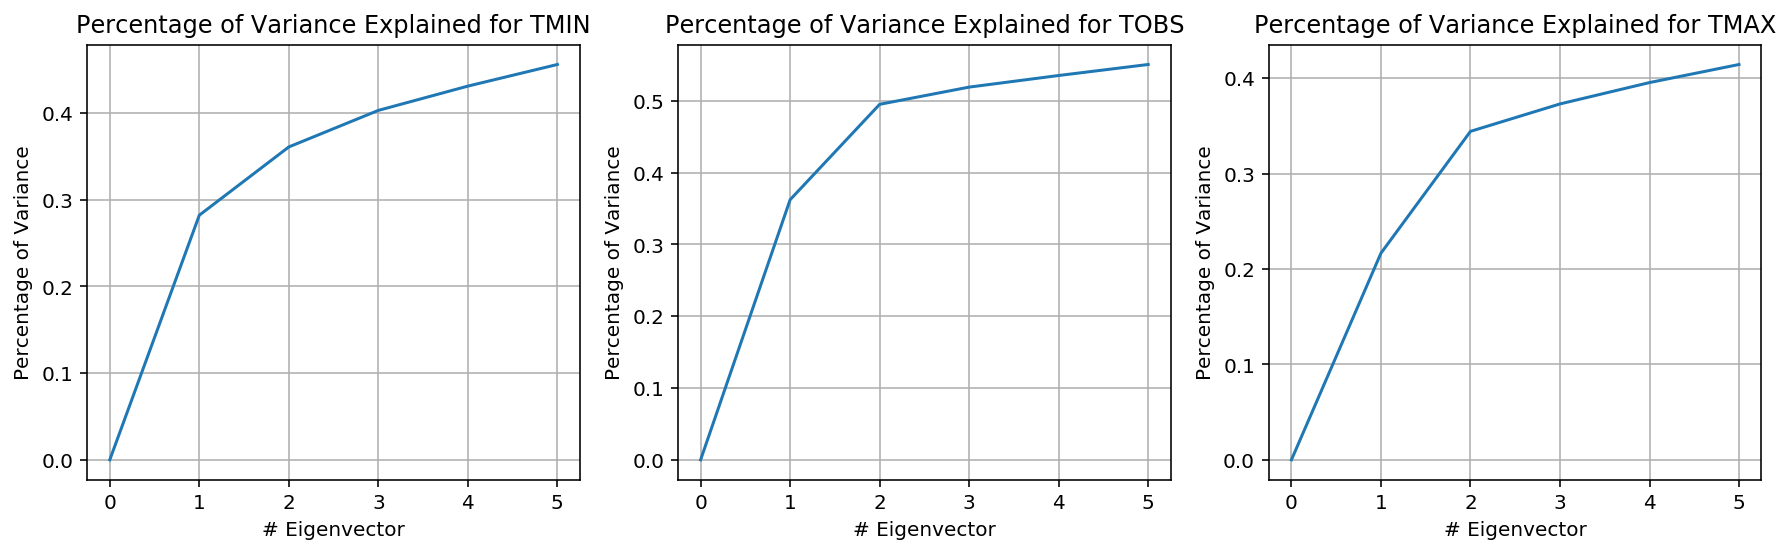

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

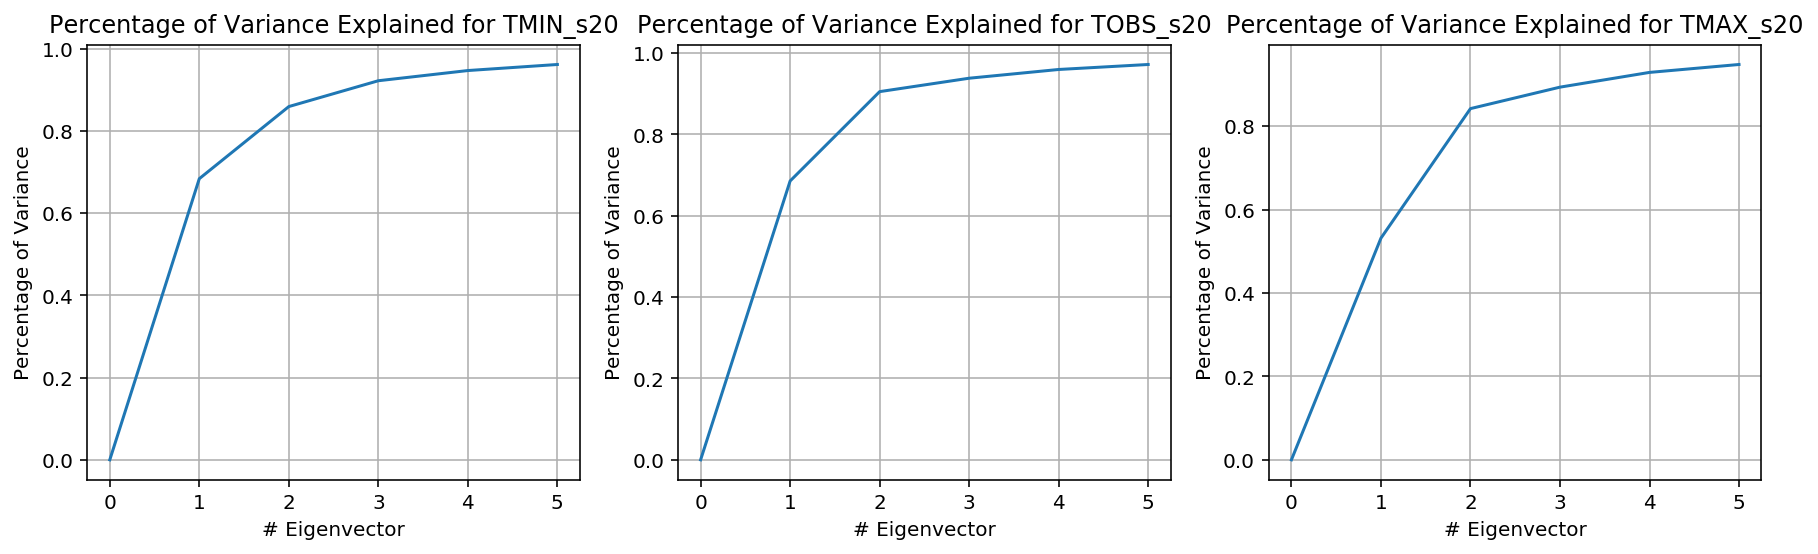

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

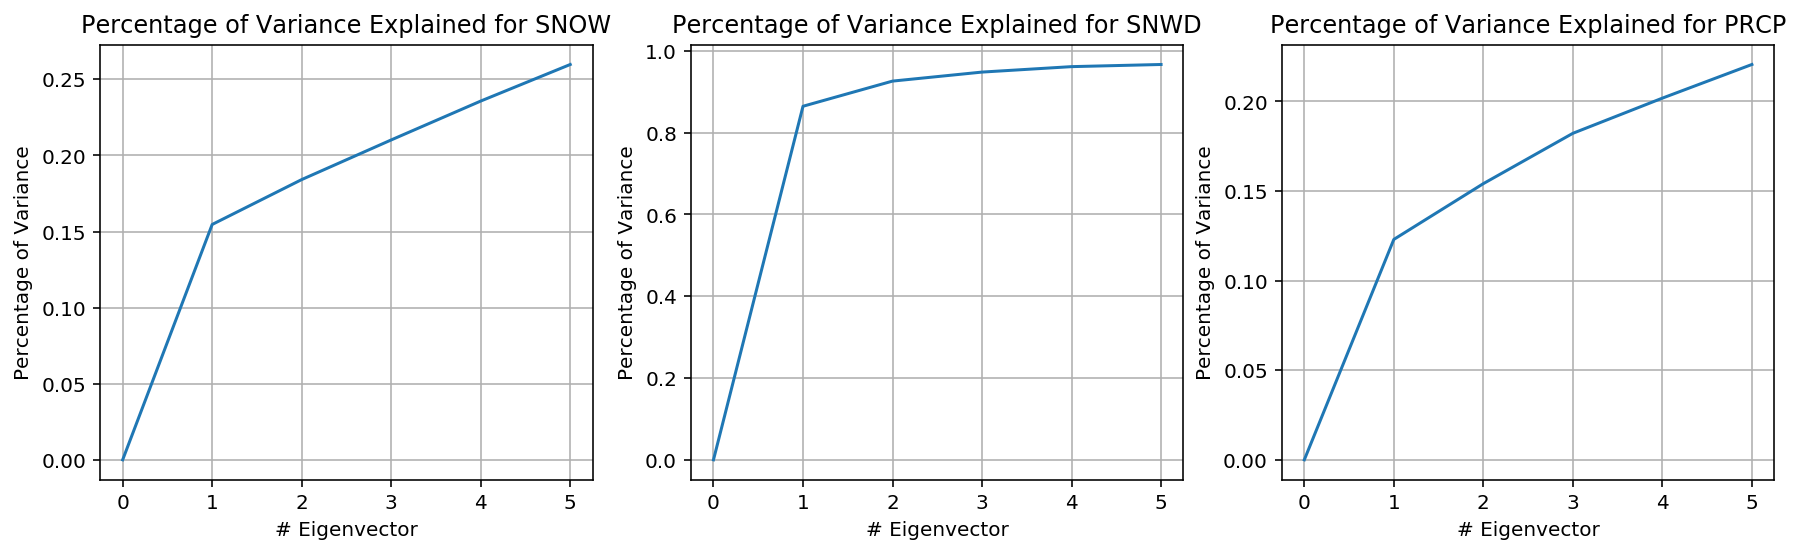

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

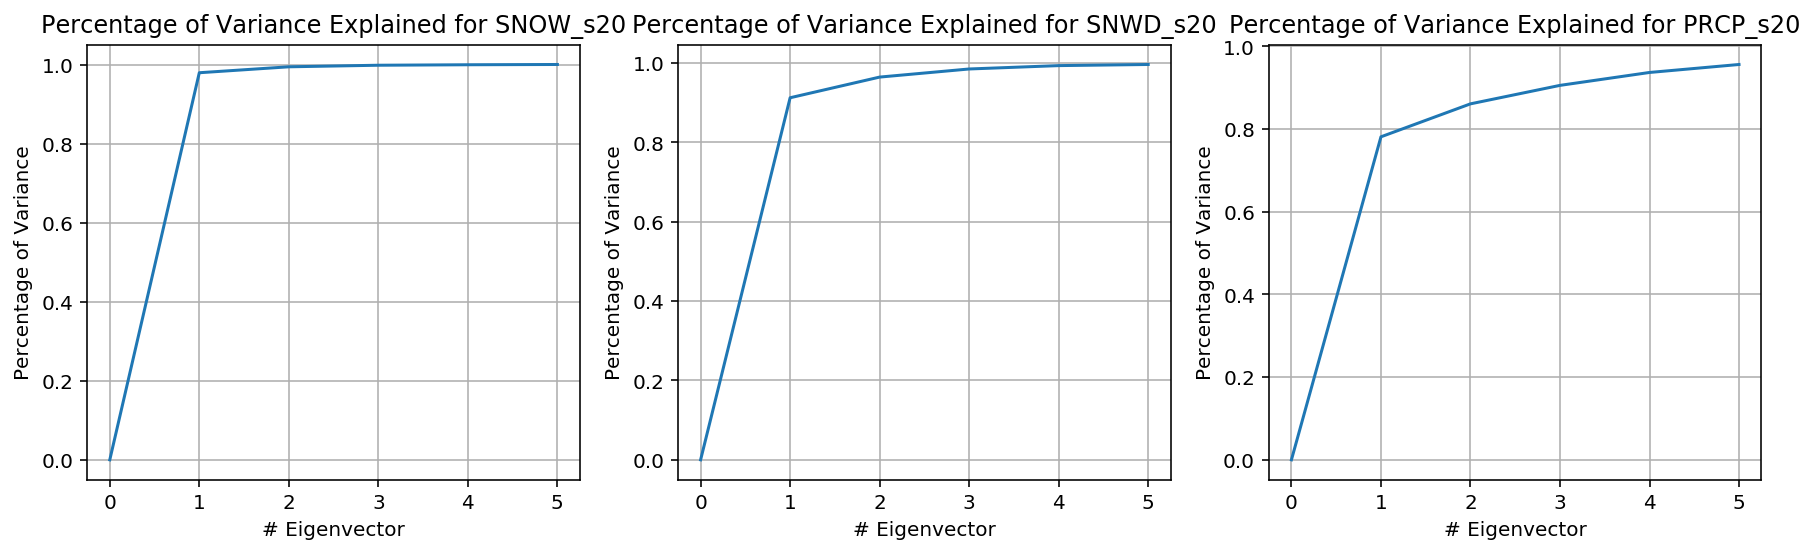

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### plotting top 3 eigenvectors

In [40]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

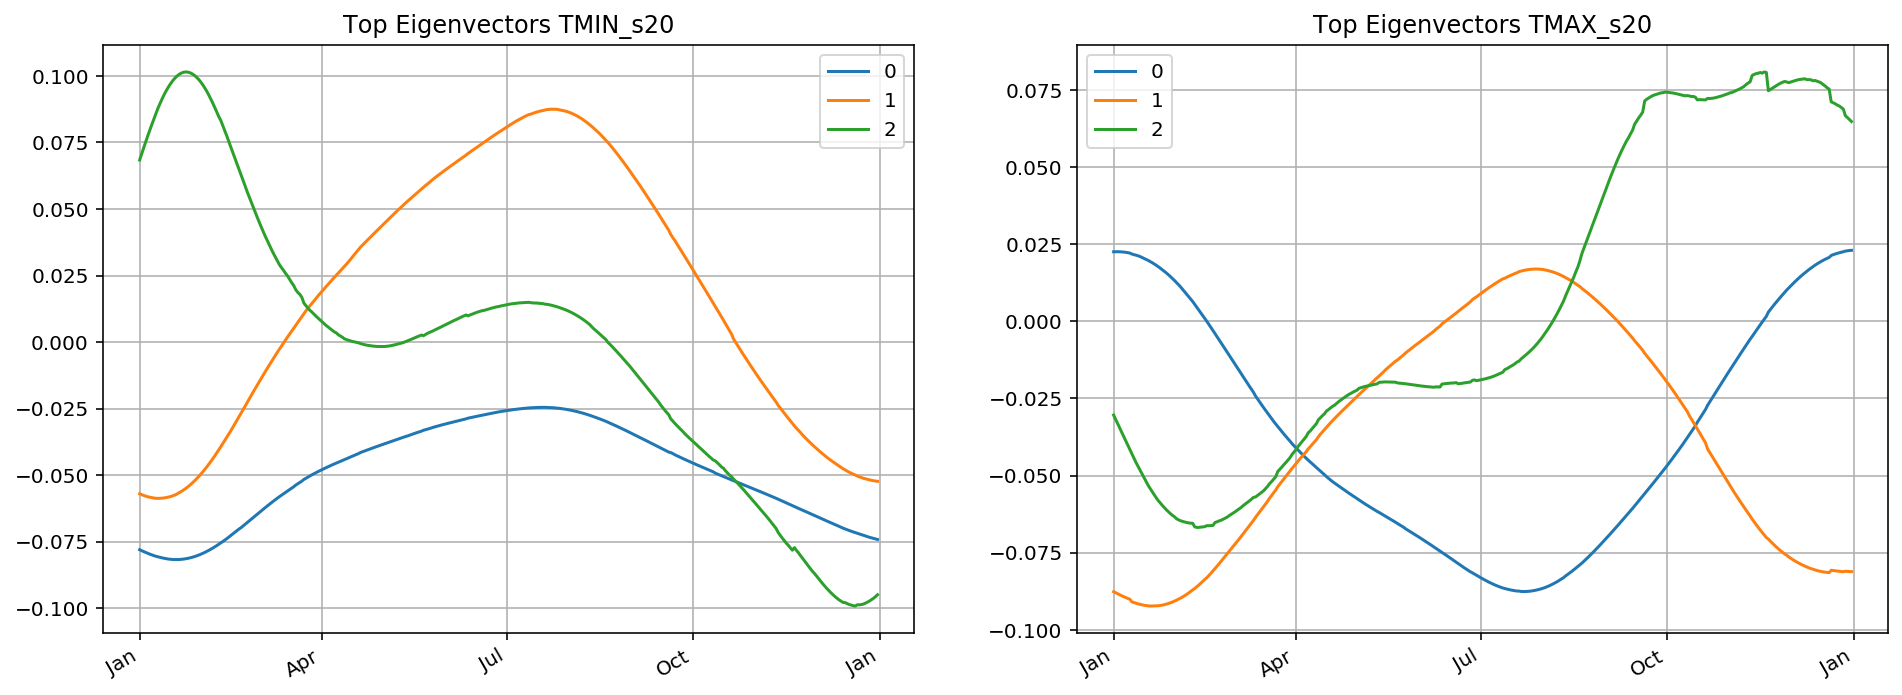

In [41]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

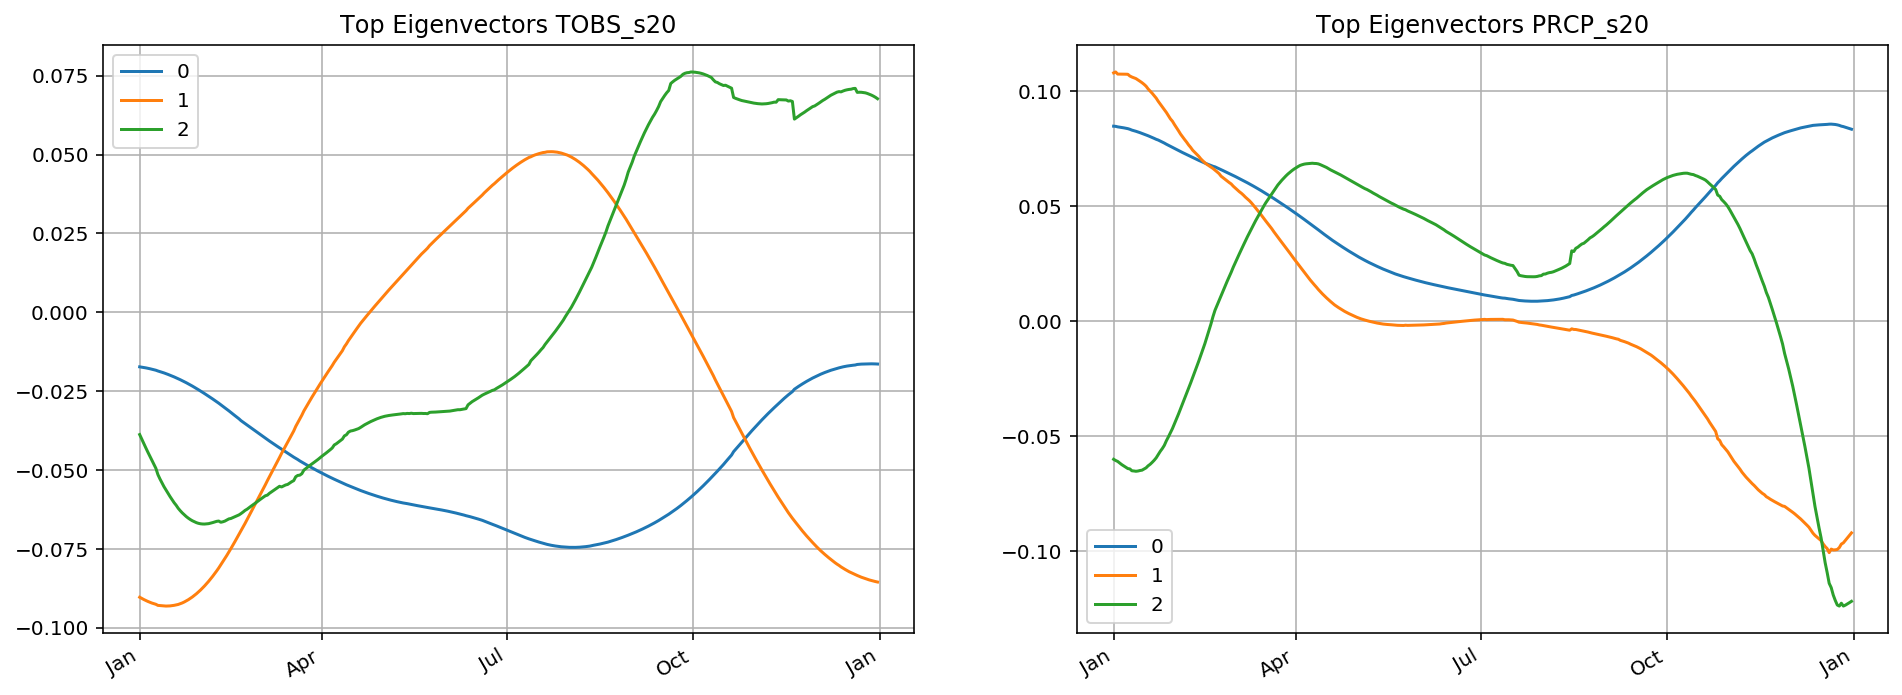

In [49]:
# plot_pair(['TOBS','PRCP'],plot_eigen)
plot_pair(['TOBS_s20','PRCP_s20'],plot_eigen)

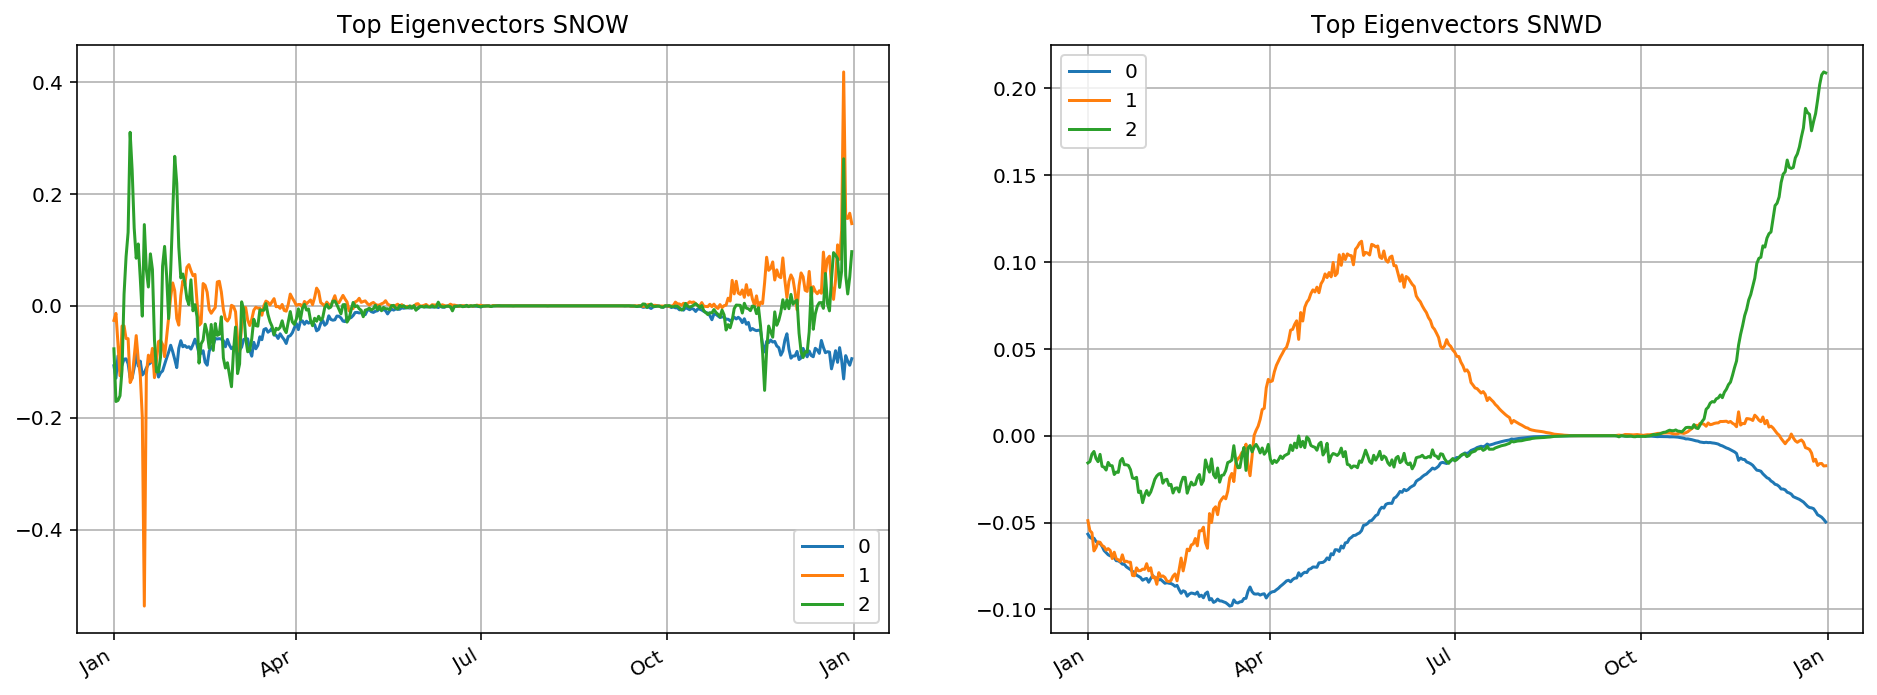

In [43]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors